generating color palette, motion 6.24 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%05d.png':
  D

creating gif


Input #0, image2, from 'frames/frame_%05d.png':
  Duration: 00:00:48.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 3600x1800 [SAR 11811:11811 DAR 2:1], 15 fps, 15 tbr, 15 tbn, 15 tbc
Input #1, png_pipe, from 'palette.png':
  Duration: N/A, bitrate: N/A
    Stream #1:0: Video: png, rgba(pc), 16x16 [SAR 1:1 DAR 1:1], 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 (png) -> paletteuse:default
  Stream #1:0 (png) -> paletteuse:palette
  paletteuse -> Stream #0:0 (gif)
Press [q] to stop, [?] for help
[image2 @ 0x5a152dac8100] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)
Output #0, gif, to 'la0_lon0_r15.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 3600x1800 [SAR 1:1 DAR 2:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  720 fps=7.0 q=-0.0 Lsize=    7881kB time=00:00:47.94 bitrate=1346.7kbits/s spe

 GIF done: la0_lon0_r15.gif


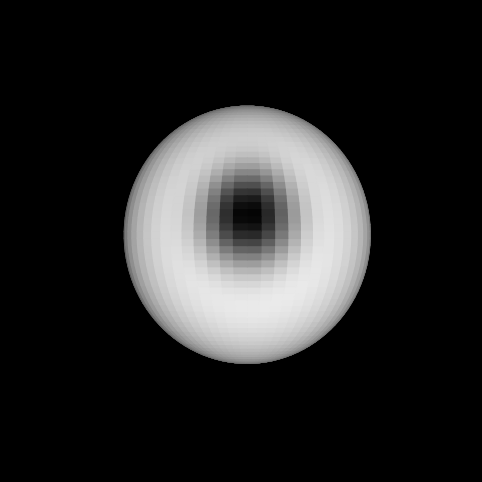

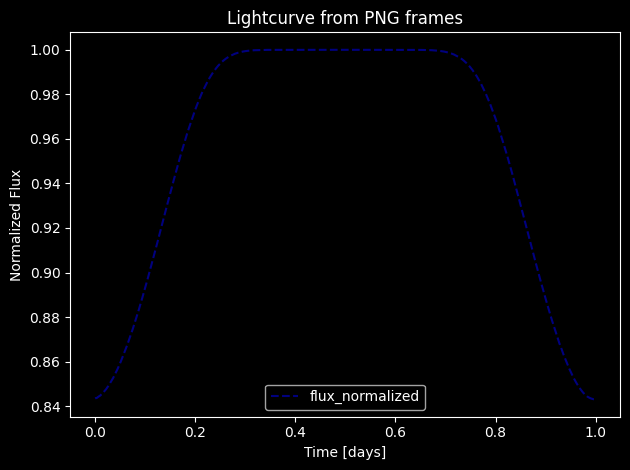

In [2]:
%matplotlib inline
#libraries
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize
import astropy.units as u
import os
from PIL import Image
import glob
import subprocess
from sklearn.metrics import mean_squared_error

os.makedirs("frames", exist_ok=True)#-------->creating folder to save the PNG

#functions 

# convertion function 
def convertion_radians(degree):
    return np.deg2rad(degree)

#function to calculate angular velocity    
def spot_theta(rotation_period, spot_colatitude, relative_shear):
    """
    Parameters:
    - rotation_period: rotation period of the sta
    - initial_latitude: latitud of spot(radians)
    - relative_shear: parameter between pole and equator
    Returns:
    - angular velocity.
    """
    latitude = np.pi / 2 - spot_colatitude #------->the spehre latitude is from 0  to 2pi, so in equator the colatitude will be pi?2
    angular_vel_equa= 2*np.pi*u.rad/rotation_period
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
    return angular_velocity  

  
def flux_plot(flux):
    ''' Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot    
    '''
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})#-----> change the name of the columns
    lc.to_csv('lc_high_name.csv')
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)#----->simple plot of lc


# limb darkening function 
def limbdarkening(u):
    '''calculate a limb darkening lineal and put it to the spehre'''
    return (1 - u * (1 - mu))

#limb darkening quadratic     
def quadratic(u1, u2, mu):
    return 1-u1*(1-mu)-u2*(1-mu)**2
    

#limb darkening logarithmic
def logarithmic(u):
    """
    Calculates the intensity of a given cell in the stellar surface using a
    logarithmic limb-darkening law.
    """
    
    return (1 - u * (1 - mu) - u * mu * np.log(mu) ** 2)



#function that create a gaussian mask to represent spots
def spot_mask(theta_mesh, spot_theta_rad,phi_mesh,spot_phi_rad,spot_radius_rad):
    '''function for creating spot mask, that could change the size and shape of the spot
    using a gaussian function
    '''
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad )**2
    return np.exp(-distance_squared / (2* sigma_squared))

def spot_mask2(theta_mesh, spot_theta_rad, phi_mesh, spot_phi_rad, spot_radius_rad):
    """
    Gaussian spot mask over a sphere using spherical distance.
    """
    # centro de la mancha
    phi0 = spot_phi_rad
    theta0 = spot_theta_rad.value

    # fórmula del ángulo entre dos puntos en la esfera
    delta = np.arccos(
        np.sin(phi_mesh) * np.sin(phi0) +
        np.cos(phi_mesh) * np.cos(phi0) * np.cos(theta_mesh - theta0)
    )

    return np.exp(-delta**2 / (2 * spot_radius_rad**2))




def spot_mask_binary(theta_mesh, spot_theta_rad, phi_mesh, spot_phi_rad, spot_radius_rad):
    """Máscara binaria: 1 dentro del radio de la mancha, 0 fuera"""
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = (delta_theta**2 + delta_phi**2)
    return np.where(distance_squared <= spot_radius_rad**2, 1, 0)


##function that creates spots

def add_spots(latitude_deg, longitude_deg, radii_deg):

    colatitude_rad = np.deg2rad(90 - latitude_deg)
    longitude_rad = np.deg2rad(longitude_deg)
    radii_rad = np.deg2rad(radii_deg)
    ang_vel = spot_theta(rotation_period, colatitude_rad, 0.2)  

    spots.append({'theta': longitude_rad * u.rad,'phi': colatitude_rad,'radius': radii_rad,'angular_velocity': ang_vel})



### function to create gif
def gif(input_pattern="frames/frame_%03d.png",output_gif="output.gif",palette="palette.png",framerate=17):
    """
    Creating GIF with ffmpeg.
    
    Parameters:
        input_pattern (str): Input pattern of the numbered images (e.g. 'frames/frame_%03d.png')
     output_gif (str): Name of the output GIF file
     palette (str): Name of the temporary palette file
     framerate (int): Frames per second of the GIF
    """
    # color palette
    palette_cmd = ["ffmpeg","-y","-i", input_pattern,"-vf", "palettegen",palette]

    # gif creation
    gif_cmd = ["ffmpeg","-y","-framerate", str(framerate),"-i", input_pattern,"-i", palette,"-lavfi", "paletteuse",output_gif]

    try:
        print("generating color palette")
        subprocess.run(palette_cmd, check=True)

        print("creating gif")
        subprocess.run(gif_cmd, check=True)

        print(f" GIF done: {output_gif}")
    except subprocess.CalledProcessError as e:
        print("something wrong:", e)

def flux_plot():
    '''
    Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot 

    '''
    frame_files = sorted(glob.glob("frames/frame_*.png"))
    fluxes = []

    for filename in frame_files:
        img = Image.open(filename).convert('L')  # Grayscale
        img_array = np.array(img, dtype=np.float64)
        flux_total = np.sum(img_array)
        fluxes.append(flux_total)

    # Normalized fluxes
    flux_norm = normalize([fluxes], norm="max")[0]
    df = pd.DataFrame(flux_norm)

    # Creating columns
    df.index.name = 'Frame'
    df.reset_index(inplace=True)
    #changing frames for days
    df['Days'] = df['Frame'] *(cadence_time.to(u.day)).value
    df = df.rename(columns={0: 'flux_normalized'})
    df = df[['Days', 'flux_normalized']]  

    # saving csv
    df.to_csv("old_model_test.csv", index=False)

    # Graficar
    ax = df.plot(x="Days", y="flux_normalized", alpha=0.5, linestyle='--', color ="blue")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("Normalized Flux")
    ax.set_title("Lightcurve from PNG frames")
    plt.tight_layout()
    plt.savefig("flux_plot.png", dpi=600)
    plt.show()

#animation Function

def animate(i, gray_texture, mu,theta_mesh, phi_mesh,
            x, y, z, ax_sphere, elev, azim, total_frames):#ax_curve, line_curve, fluxes, total_frames):
    """ Function where is created the motion and call functions"""
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)
    texture = np.copy(gray_texture)


    for spot in spots:
        theta_mov = spot['theta'] + spot['angular_velocity'] * i * cadence_time.to(u.day)
        mask = spot_mask(theta_mesh, theta_mov, phi_mesh, spot['phi'], spot['radius'])
        texture *= (1 - mask)  # Add texture to spot

    # Plot surface
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(texture), shade=False)
    print(f"Procesando frame {i+1}/{total_frames}, motion {theta_mov:.2f}",  end='\r')  # -------> to see the process
    
    # Png saves
    filename = f"frames/frame_{i:05d}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
    return[surf]

if __name__ == '__main__':
    
    # Stellar parameters 
    r = 1* u.R_sun
    res = 60#--->resolution
    constant = 0.8  # limb darkening coefficient
    rotation_period = 1* u.day #--->rotation period of the star
    u1 = 0.4
    u2 =0.3# limb darkening coefficients
    
    # Point of view of the sphere
    elev = 0
    azim = 0
    
     #list of spots
    spots = []
    
    #adding spots
    #add_spots(40, 345, 10)
    #add_spots(-30, 10, 10)
    add_spots(10, 0, 15)
    
   
    
    #parameters of how many days periods
    observing_baseline_days = 1* u.day#----> Observation time
    cadence_time = 2 * u.minute#----> Cadence
    
    # frames
    total_frames = (observing_baseline_days / cadence_time).decompose().value
    total_frames = int(total_frames) 
    
    #Parameter of differential rotation
    relative_shear_coeff = 0.4
    
    #creating angles
    theta = np.linspace(0, 2*np.pi, res)
    phi = np.linspace(0, np.pi, res)
    
    #meshgrid for creation of the sphere surface
    theta_mesh, phi_mesh = np.meshgrid(theta, phi)
    
    x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
    y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
    z = r * np.cos(phi_mesh)
    
    # gray texture 
    gray_texture = np.ones((res, res))  # intensity white==1
    #convertion paraneters
    elev_rad = convertion_radians(elev)
    azim_rad = convertion_radians(azim)
    
    v_x = np.cos(elev_rad) * np.cos(azim_rad)
    v_y = np.cos(elev_rad) * np.sin(azim_rad)
    v_z = np.sin(elev_rad)
    
    # Limb darkening
    mu = (x * v_x + y * v_y + z * v_z) / r
    mu = np.clip(mu, 0, 1)
    
    #lineal_darkening = limbdarkening(constant)
    #gray_texture *= lineal_darkening
    quadratic_darkening = quadratic(u1,u2,mu)
    gray_texture *= quadratic_darkening
    
      
    # Figure
    plt.style.use('dark_background')# -----> dark background
    fig = plt.figure(figsize=(12, 6))
    ax_sphere = fig.add_subplot(projection='3d') 

    ax_sphere.set_box_aspect((0.98, 1, 0.95))#-------> symtries of the sun 
 
    ax_sphere.set_axis_off()
    


    for i in range(total_frames):
        animate(i, gray_texture, mu,theta_mesh, phi_mesh, x, y, z, ax_sphere, elev, azim, total_frames)
        plt.savefig(f"frames/frame_{i:05d}.png", dpi=300)

    gif(input_pattern="frames/frame_%05d.png", output_gif="la0_lon0_r15.gif",framerate=15)
    flux_plot()

  



In [1]:
spots

NameError: name 'spots' is not defined

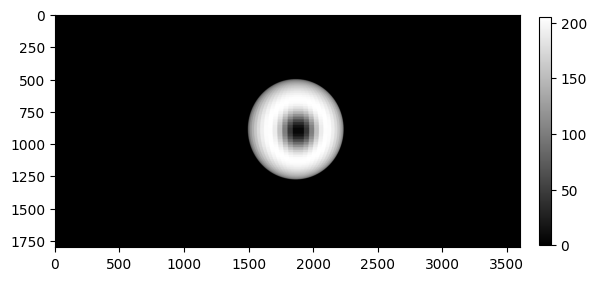

In [34]:
plt.style.use('default')
img = Image.open("frames/frame_012.png").convert('L')  # Grayscale
img_array = np.array(img, dtype=np.float64)
flux_total = np.sum(img_array)
fig, ax = plt.subplots()

# Mostrar la imagen
img = ax.imshow(img_array, cmap="gray")

# Agregar colorbar con el mismo alto que la imagen
cbar = plt.colorbar(img, ax=ax, fraction=0.023, pad=0.04)
plt.savefig('texture.png')
plt.show()


### Taking the images and making a mean of intensity

### creating a gif again

In [ ]:
%matplotlib inline
#libraries
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize
import astropy.units as u
import os
from PIL import Image
import glob
import subprocess

os.makedirs("frames", exist_ok=True)#-------->creating folder to save the PNG
os.makedirs("light_curve", exist_ok=True)#-------->creating folder to save the light_curve

#functions 

# convertion function 
def convertion_radians(degree):
    return np.deg2rad(degree)

#function to calculate angular velocity    
def spot_theta(rotation_period, spot_colatitude, relative_shear):
    """
    Parameters:
    - rotation_period: rotation period of the sta
    - initial_latitude: latitud of spot(radians)
    - relative_shear: parameter between pole and equator
    Returns:
    - angular velocity.
    """
    latitude = np.pi / 2 - spot_colatitude #------->the spehre latitude is from 0  to 2pi, so in equator the colatitude will be pi?2
    angular_vel_equa= 2*np.pi*u.rad/rotation_period
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
    return angular_velocity  

  
def flux_plot(flux):
    ''' Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot    
    '''
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})#-----> change the name of the columns
    lc.to_csv('lc_high_name.csv')
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)#----->simple plot of lc


# limb darkening function 
def limbdarkening(u):
    '''calculate a limb darkening lineal and put it to the spehre'''
    return (1 - u * (1 - mu))

#limb darkening quadratic     
def quadratic(u):
    """
    Calculates the intensity of a given cell in the stellar surface using a
    quadratic limb-darkening law.
  """

    return (1 - u * (1 - mu) - u * (1 - mu) ** 2)

#limb darkening logarithmic
def logarithmic(u):
    """
    Calculates the intensity of a given cell in the stellar surface using a
    logarithmic limb-darkening law.
    """
    
    return (1 - u * (1 - mu) - u * mu * np.log(mu) ** 2)




#function that create a gaussian mask to represent spots
def spot_mask(theta_mesh, spot_theta_rad,phi_mesh,spot_phi_rad,spot_radius_rad):
    '''function for creating spot mask, that could change the size and shape of the spot
    using a gaussian function
    '''
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    return np.exp(-distance_squared**2 / (2* sigma_squared))

def spot_mask_binary(theta_mesh, spot_theta_rad, phi_mesh, spot_phi_rad, spot_radius_rad):
    """Máscara binaria: 1 dentro del radio de la mancha, 0 fuera"""
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    return np.where(distance_squared <= spot_radius_rad**2, 1, 0)


##function that creates spots

def add_spots(latitude_deg, longitude_deg, radii_deg):

    colatitude_rad = np.deg2rad(90 - latitude_deg)
    longitude_rad = np.deg2rad(longitude_deg)
    radii_rad = np.deg2rad(radii_deg)
    ang_vel = spot_theta(rotation_period, colatitude_rad, 0.2)  

    spots.append({'theta': longitude_rad * u.rad,'phi': colatitude_rad,'radius': radii_rad,'angular_velocity': ang_vel})

ve_l-70_lo44_r2.5.csv
lightcurve_l-70_lo20_r11.5.csv  lightcurve_l-70_lo44_r3.5.csv
lightcurve_l-70_lo20_r12.5.csv  lightcurve_l-70_lo44_r4.5.csv
lightcurve_l-70_lo20_r13.5.csv  lightcurve_l-70_lo44_r5.5.csv
lightcurve_l-70_lo20_r14.5.csv  lightcurve_l-70_lo44_r6.5.csv
lightcurve_l-70_lo20_r15.5.csv  lightcurve_l-70_lo44_r7.5.csv
lightcurve_l-70_lo20_r1.5.csv   lightcurve_l-70_lo44_r8.5.csv
lightcurve_l-70_lo20_r16.5.csv  lightcur

### function to create gif
def gif(input_pattern="frames/frame_%03d.png", output_dir="simulation_starspot",output_gif="output.gif",palette="palette.png", framerate=17):
    """
    Creates a GIF from a sequence of PNG frames using ffmpeg.

    Parameters:
        input_pattern (str): Pattern of input image filenames.
        output_dir (str): Directory to save the output GIF and palette.
        output_gif (str): Name of the output GIF file.
        palette (str): Name of the temporary palette file.
        framerate (int): Frames per second for the GIF.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    output_gif_path = os.path.join(output_dir, output_gif)
    palette_path = os.path.join(output_dir, palette)

    # Step 1: Generate color palette
    palette_cmd = ["ffmpeg", "-y","-i", input_pattern,"-vf", "palettegen",palette_path]

    # Step 2: Create GIF using the palette
    gif_cmd = ["ffmpeg", "-y","-framerate", str(framerate),"-i", input_pattern,"-i", palette_path,"-lavfi", "paletteuse",output_gif_path]

    try:
        print("🎨 Generating color palette...")
        subprocess.run(palette_cmd, check=True)

        print("🎞️ Creating GIF...")
        subprocess.run(gif_cmd, check=True)

        print(f"✅ GIF saved at: {output_gif_path}")
    except subprocess.CalledProcessError as e:
        print("❌ Something went wrong with ffmpeg:", e)

def flux_plot():
    '''
    Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot 

    '''
    frame_files = sorted(glob.glob("frames/frame_*.png"))
    fluxes = []

    for filename in frame_files:
        img = Image.open(filename).convert('L')  # Grayscale
        img_array = np.array(img, dtype=np.float64)
        flux_total = np.sum(img_array)
        fluxes.append(flux_total)

    # Normalized fluxes
    flux_norm = normalize([fluxes], norm="max")[0]
    df = pd.DataFrame(flux_norm)

    # Creating columns
    df.index.name = 'Frame'
    df.reset_index(inplace=True)
    #changing frames for days
    df['Days'] = df['Frame'] *(cadence_time.to(u.day)).value
    df = df.rename(columns={0: 'flux_normalized'})
    df = df[['Days', 'flux_normalized']]  

    # saving csv
    df.to_csv("starspot.csv", index=False)

    # Graficar
    ax = df.plot(x="Days", y="flux_normalized", alpha=0.5, linestyle='--', color ="blue")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("Normalized Flux")
    ax.set_title("Lightcurve from PNG frames")
    plt.tight_layout()
    plt.show()

#animation Function

def animate(i, gray_texture, mu,theta_mesh, phi_mesh,
            x, y, z, ax_sphere, elev, azim, total_frames):#ax_curve, line_curve, fluxes, total_frames):
    """ Function where is created the motion and call functions"""
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)
    texture = np.copy(gray_texture)

    for spot in spots:
        theta_mov = spot['theta'] + spot['angular_velocity'] * i * cadence_time.to(u.day)
        mask = spot_mask(theta_mesh, theta_mov, phi_mesh, spot['phi'], spot['radius'])
        texture *= (1 -  mask)  # Add texture to spot

    # Plot surface
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(texture), shade=False)
    print(f"Procesando frame {i+1}/{total_frames}, motion {theta_mov:.2f}",  end='\r')  # -------> to see the process
    
    # Png saves
    filename = f"frames/frame_{i:03d}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
    return[surf]

if __name__ == '__main__':
    
    # Stellar parameters 
    r = 1* u.R_sun
    res = 60#--->resolution
    constant = 0.8  # limb darkening coefficient
    rotation_period = 1* u.day #--->rotation period of the star
    
    # Point of view of the sphere
    elev = 0
    azim = 0
    
     #list of spots
    spots = []
    
    #adding spots
    #add_spots(30, 45, 10)
    #add_spots(-20, 90, 15)
    #add_spots(0, 180, 10)

    
    #parameters of how many days periods
    observing_baseline_days = 5* u.day#----> Observation time
    cadence_time = 30 * u.minute#----> Cadence
    
    # frames
    total_frames = (observing_baseline_days / cadence_time).decompose().value
    total_frames = int(total_frames) 
    
    #Parameter of differential rotation
    relative_shear_coeff = 0.2
    
    #creating angles
    theta = np.linspace(0, 2*np.pi, res)
    phi = np.linspace(0, np.pi, res)
    
    #meshgrid for creation of the sphere surface
    theta_mesh, phi_mesh = np.meshgrid(theta, phi)
    
    x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
    y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
    z = r * np.cos(phi_mesh)
    
    # gray texture 
    gray_texture = np.ones((res, res))  # intensity white==1
    
    #convertion paraneters
    elev_rad = convertion_radians(elev)
    azim_rad = convertion_radians(azim)
    
    v_x = np.cos(elev_rad) * np.cos(azim_rad)
    v_y = np.cos(elev_rad) * np.sin(azim_rad)
    v_z = np.sin(elev_rad)
    
    # Limb darkening
    mu = (x * v_x + y * v_y + z * v_z) / r
    mu = np.clip(mu, 0, 1)
    
    lineal_darkening = limbdarkening(constant)
    gray_texture *= lineal_darkening
      
    # Figure
    plt.style.use('dark_background')# -----> dark background
    fig = plt.figure(figsize=(12, 6))
    ax_sphere = fig.add_subplot(projection='3d') 

    ax_sphere.set_box_aspect((0.98, 1, 0.95))#-------> symtries of the sun 
 
    ax_sphere.set_axis_off()
    
    
#  Grid search parameters
    latitudes = np.arange(-70, 70, 2)
    longitudes = np.arange(0, 360, 2)
    radios = np.arange(0, 25, 1)  # en grados

    simulacion_id = 0  # identification of simulation

    for lat in latitudes:
        print(f" Simulatin{(simulacion_id+1)}/{len(latitudes)}")
        for lon in longitudes:
            for radius in radios:

                #simulacion_id += 1
                print(f" Simulatin lat={lat}, lon={lon}, radius={radius}")

                # clean frames
                for f in glob.glob("frames/*.png"):
                    os.remove(f)

                # Reset mancha
                spots = []
                add_spots(lat, lon, radius)

                # Reset texture
                gray_texture = np.copy(gray_texture)


                for i in range(total_frames):
                    animate(i, gray_texture, mu, theta_mesh, phi_mesh, x, y, z,
                            ax_sphere, elev, azim, total_frames)

                # Name gif
                gif_name = f"gif_l{lat}_lo{lon}_r{radius}.gif"
                gif(input_pattern="frames/frame_%03d.png", output_gif=gif_name, framerate=15)

                # saving lc 
                fluxes = []
                frame_files = sorted(glob.glob("frames/frame_*.png"))
                for filename in frame_files:
                    img = Image.open(filename).convert('L')
                    img_array = np.array(img, dtype=np.float64)
                    flux_total = np.sum(img_array)
                    fluxes.append(flux_total)

                flux_norm = normalize([fluxes], norm="max")[0]
                df = pd.DataFrame(flux_norm)
                df.index.name = 'Frame'
                df.reset_index(inplace=True)
                df['Days'] = df['Frame'] * (cadence_time.to(u.day)).value
                df = df.rename(columns={0: 'flux_normalized'})
                df = df[['Days', 'flux_normalized']]
                df.to_csv(f"light_curve/lightcurve_l{lat}_lo{lon}_r{radius}.csv", index=False)


  


 Simulatin1/10
 Simulatin lat=0, lon=0, radius=5
Procesando frame 64/240, motion 8.25 rad

In [1]:
def triangulateSphere(ax, k=30, cmap=cm.magma):
  
    # domain parametrization
    U = np.linspace(0, 2 * np.pi, k)
    V = np.linspace(0, np.pi, k)
    [X, Y] = np.meshgrid(U, V)

    # sphere parametrization
    S1 = np.cos(X) * np.sin(Y)
    S2 = np.sin(X) * np.sin(Y)
    S3 = np.cos(Y)

    # triangulate the points in [0,2pi] x [0,pi]
    tri = Delaunay(np.array([X.flatten(), Y.flatten()]).T)
    
    # plot the sphere
    ax.plot_trisurf(
        S1.flatten(), S2.flatten(), S3.flatten(),
        triangles=tri.simplices, cmap=cmap
    )
    
triangulateSphere(ax)
plt.show()

NameError: name 'cm' is not defined

generating color palettemotion 5.43 rad


ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/ruben/miniconda3/envs/tesis --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'frames/frame_%03d.png':
  D

creating gif


Output #0, gif, to 'lc_dummy.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, pal8, 3600x1800 [SAR 1:1 DAR 2:1], q=2-31, 200 kb/s, 15 fps, 100 tbn, 15 tbc (default)
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=   48 fps=6.1 q=-0.0 Lsize=     737kB time=00:00:03.14 bitrate=1922.7kbits/s speed=0.398x    
video:737kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.002650%


 GIF done: lc_dummy.gif


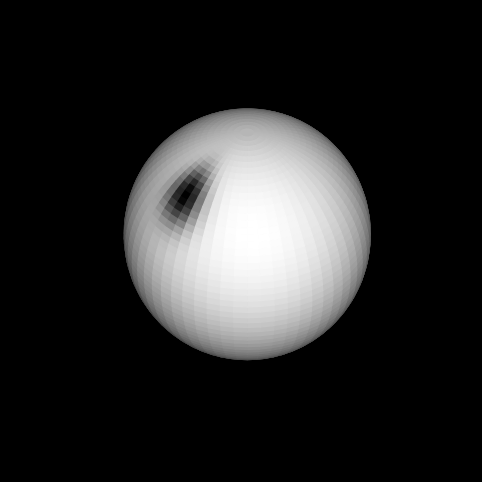

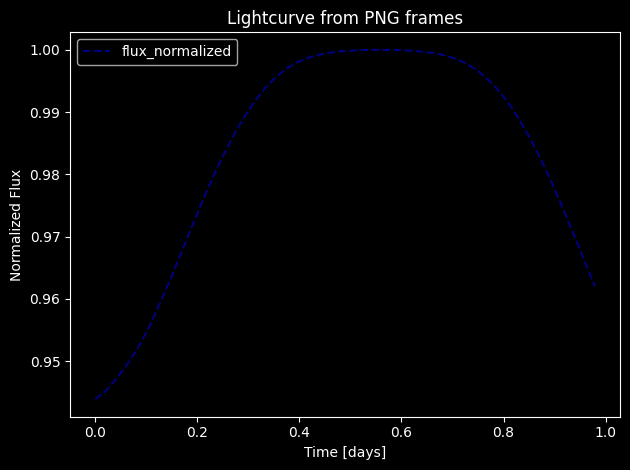

Generate spherical grid...
start render...


NameError: name 'ax' is not defined

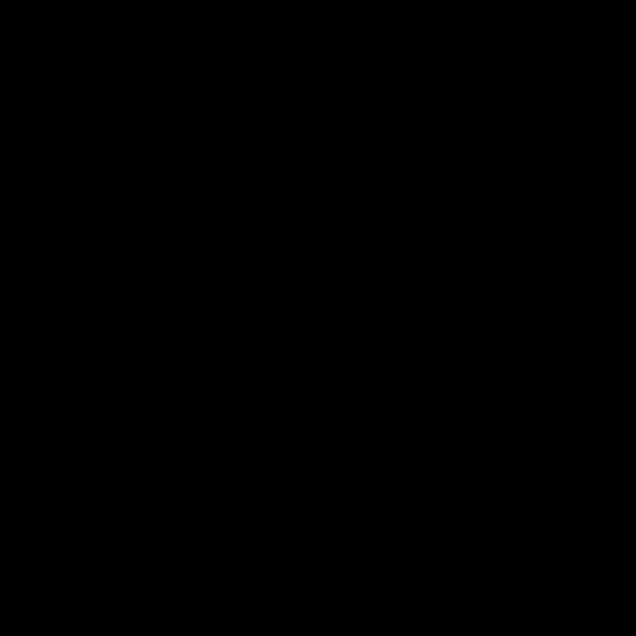

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
import os
from PIL import Image
import glob
import subprocess
import matplotlib as mpl

os.makedirs("frames", exist_ok=True)

# ---- fibonacci sphere ----
def fibonacci_sphere(n_points):
    """generating equal points to distributing in sphere"""
    indices = np.arange(n_points, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/n_points)  # [0, π]
    theta = np.pi * (1 + 5**0.5) * indices  # aureo angle
    
    return phi, theta % (2*np.pi)  # etting values between 0 and 2π

def cartesian_from_spherical(phi, theta, r=1.0):
    """Convert spherical coordinates to cartesians"""
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    return x, y, z

def spot_mask_geodesic(x, y, z, spot_center, spot_radius_rad):
    """Máscara usando distancia geodésica real con optimización"""
    # Convert the spot_center vector to a unit vector (of length 1).
    center_norm = spot_center / np.linalg.norm(spot_center)
    
    # Product
    positions = np.stack([x, y, z], axis=-1)
    norms = np.linalg.norm(positions, axis=-1, keepdims=True)
    pos_norm = positions / np.clip(norms, 1e-10, None)  #np.clip avoids division by zero (if a vector had length 0).
    
    dot_product = np.sum(pos_norm * center_norm, axis=-1) #Calculation of the Product Point
    dot_product = np.clip(dot_product, -1, 1) #Force the values to be between [-1, 1]. This is necessary because numerical errors may produce values slightly outside this range.
    
    # central_angle is the geodesic distance (in radians) between each point on the surface and the center of the spot.
    central_angle = np.arccos(dot_product)
    
    return np.exp(-(central_angle**2) / (2 * spot_radius_rad**2))

#function to calculate angular velocity  
def spot_theta(rotation_period, spot_colatitude, relative_shear):
    ''' Parameters:
    - rotation_period: rotation period of the sta
    - spot_colatitude: latitud of spot(radians)
    - relative_shear: parameter between pole and equator
    Returns:
    - angular velocity. '''
    
    latitude = np.pi / 2 - spot_colatitude
    angular_vel_equa = 2*np.pi*u.rad/rotation_period
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
    return angular_velocity

def limbdarkening(u, mu):
    ''' lineal limb darkening'''
    return (1 - u * (1 - mu))

def add_spots(latitude_deg, longitude_deg, radii_deg):
    colatitude_rad = np.deg2rad(90 - latitude_deg)
    longitude_rad = np.deg2rad(longitude_deg)
    radii_rad = np.deg2rad(radii_deg)
    ang_vel = spot_theta(rotation_period, colatitude_rad, 0.2)  
    spots.append({
        'theta': longitude_rad * u.rad,
        'phi': colatitude_rad,
        'radius': radii_rad,
        'angular_velocity': ang_vel
    })

def gif(input_pattern="frames/frame_%03d.png", output_gif="output.gif", 
        palette="palette.png", framerate=17):
    palette_cmd = [
        "ffmpeg", "-y", "-i", input_pattern,
        "-vf", "palettegen", palette
    ]
    gif_cmd = [
        "ffmpeg", "-y", "-framerate", str(framerate),
        "-i", input_pattern, "-i", palette,
        "-lavfi", "paletteuse", output_gif
    ]
    try:
        subprocess.run(palette_cmd, check=True)
        subprocess.run(gif_cmd, check=True)
        print(f"GIF creado: {output_gif}")
    except subprocess.CalledProcessError as e:
        print("Error en ffmpeg:", e)

def flux_plot():
    '''
    Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot 

    '''
    frame_files = sorted(glob.glob("frames/frame_*.png"))
    fluxes = []

    for filename in frame_files:
        img = Image.open(filename).convert('L')  # Grayscale
        img_array = np.array(img, dtype=np.float64)
        flux_total = np.sum(img_array)
        fluxes.append(flux_total)

    # Normalized fluxes
    #flux_norm.append(flux_total / fluxes[i])
    #flux_norm = normalize([fluxes], norm="max")[0]
    flux_norm = np.array(fluxes)/np.max(np.array(fluxes))
    df = pd.DataFrame(flux_norm)

    # Creating columns
    df.index.name = 'Frame'
    df.reset_index(inplace=True)
    #changing frames for days
    df['Days'] = df['Frame'] *(cadence_time.to(u.day)).value
    df = df.rename(columns={0: 'flux_normalized'})
    df = df[['Days', 'flux_normalized']]  

    # saving csv
    df.to_csv("lc_dummy.csv", index=False)

    # plotting
    
    ax = df.plot(x="Days", y="flux_normalized", alpha=0.5, linestyle='--', color ="k")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("Normalized Flux")
    ax.set_title("Lightcurve from PNG frames")
    plt.style.use('default')
    plt.tight_layout()
    plt.savefig("flux_plot.png", dpi=600)
    plt.show()

# ---- Función de animación corregida ----
def animate(i, points, base_intensity, ax_sphere, elev, azim, total_frames, vmin, vmax):
    ax.sphereclear()
    ax.set_axis_off()
    ax.view_init(elev=elev, azim=azim)
    
    # copying the texture

    intensity = np.copy(base_intensity)
    
    # adding several spots
    for spot in spots:
        # Calcular nueva posición de la mancha
        theta_mov = spot['theta'] + spot['angular_velocity'] * i * cadence_time.to(u.day)
        
        # Calculating position of the spot
        spot_x = r_val * np.sin(spot['phi']) * np.cos(theta_mov.value)
        spot_y = r_val * np.sin(spot['phi']) * np.sin(theta_mov.value)
        spot_z = r_val * np.cos(spot['phi'])
        spot_center = np.array([spot_x, spot_y, spot_z])
        
        # creating a mask
        mask = spot_mask_geodesic(points[:, 0], points[:, 1], points[:, 2], 
                                 spot_center, spot['radius'])
        intensity *= (1 -  mask)  # Reducción de intensidad en manchas
    
    # scatter plot
    sc = ax_sphere.scatter(
        points[:, 0], points[:, 1], points[:, 2], 
        c=intensity, 
        cmap='gray', 
        s=1, 
        alpha=0.9,
        vmin=0,  # Mínimo fijo
        vmax=1.0   # Máximo fijo
    )
    
    # Configurar límites de la esfera
    max_range = r_val * 1.1
    ax_sphere.set_xlim(-max_range, max_range)
    ax_sphere.set_ylim(-max_range, max_range)
    ax_sphere.set_zlim(-max_range, max_range)
    
    print(f"Procesando frame {i+1}/{total_frames}", end='\r')
    plt.savefig(f"frames/frame_{i:03d}.png", dpi=150, bbox_inches='tight')
    return None

# ---- main ----
if __name__ == '__main__':
    # stellar parameter
    r_val = 1.0
    n_points = 80000
    constant = 0.8  # limb darkening coefficients
    rotation_period = 1.5 * u.day
    
    # Point of view
    elev = 0
    azim = 0
    
    # List of spots
    spots = []
    
    #adding spots
    add_spots(-30, 0, 1)      
    add_spots(60, 90, 8)     
    add_spots(0, 0, 10)  
    
    # base lines time parameter
    observing_baseline_days = 3 * u.day
    cadence_time = 3 * u.minute
    total_frames = int((observing_baseline_days / cadence_time).decompose().value)
    
    # spherical grid with fibonacci points
    print("Generate spherical grid...")
    phi, theta = fibonacci_sphere(n_points)
    x, y, z = cartesian_from_spherical(phi, theta)
    points = np.vstack([x, y, z]).T
    
    # Calculate point of view
    elev_rad = np.deg2rad(elev) #elevation of point of view
    azim_rad = np.deg2rad(azim)#azimut of point of view
    
    v_x = np.cos(elev_rad) * np.cos(azim_rad)
    v_y = np.cos(elev_rad) * np.sin(azim_rad)
    v_z = np.sin(elev_rad)
    
    # rearrange of calculating mu parameter for limb darkening
    mu = (points[:, 0] * v_x + points[:, 1] * v_y + points[:, 2] * v_z) / r_val
    mu = np.clip(mu, 0, 1)
    base_intensity = limbdarkening(constant, mu)# applying to the texture
    
    #    Calculates the extreme values of the base intensity: 
    #vmin: Minimum value of intensity in the whole star.
    #vmax: Maximum value of intensity over the whole star.
    vmin =  0.0
    vmax =  1.0

   # Defines a reference range for color mapping that will be used consistently across all frames.
 
    
    # background configurations
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(10, 8))
    ax_sphere = fig.add_subplot(111, projection='3d') 
    ax_sphere.set_axis_off()
    ax_sphere.set_box_aspect([1, 1, 1])
    
    # Límits
    max_range = r_val * 1.1
    ax_sphere.set_xlim(-max_range, max_range)
    ax_sphere.set_ylim(-max_range, max_range)
    ax_sphere.set_zlim(-max_range, max_range)
    
    # Generating animation
    print("start render...")
    for i in range(total_frames):
        animate(i, points, base_intensity, ax_sphere, elev, azim, total_frames, vmin, vmax)
    
    # Create gif an light curve
    print("\nCreando GIF...")
    gif(input_pattern="frames/frame_%03d.png", output_gif="lc_dummy.gif", framerate=15)
    print("Generating ligthcurve..")
    plt.style.use('default')
    flux_plot()
